<a href="https://colab.research.google.com/github/ManishSuhas0026/Fashion-Product-Recommendation-using-Multimodel/blob/main/2348530_Fashion_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
from PIL import Image
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel, TFBertModel
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, ndcg_score
from sklearn.metrics import average_precision_score, ndcg_score

In [ ]:
data_path = "Fashion model/Fashion Dataset v2.csv"
df = pd.read_csv(data_path)

In [ ]:
df.head(5)

,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,16331376,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,"Kurta, Trousers, Dupatta",4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,14709966,Nayo Women Red Floral Printed Kurta With Trous...,"Kurta, Trouser, Dupatta",3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,11056154,AHIKA Women Black & Green Printed Straight Kurta,Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DESTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DESTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_description'] = df['description'].apply(preprocess_text)

In [ ]:
label_encoders = {}
categorical_cols = ['products', 'colour', 'brand']
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['processed_description'])

In [ ]:
image_dir = "Fashion model/images"
os.makedirs(image_dir, exist_ok=True)

In [ ]:
def image_exists(img_path):
    return os.path.exists(img_path)

In [ ]:
df['img_path'] = df['img'].apply(lambda x: os.path.join(image_dir, os.path.basename(x)))
df = df[df['img_path'].apply(image_exists)]

In [ ]:
def replace_missing_images(img_path):
    if image_exists(img_path):
        return img_path
    else:
        # Replace missing image with placeholder image
        placeholder_img_path = "path_to_placeholder_image.jpg"  # Path to placeholder image
        return placeholder_img_path

df['img_path'] = df['img_path'].apply(replace_missing_images)

In [ ]:
def load_and_resize_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size, resample=Image.LANCZOS)  # Use LANCZOS for resizing
    img_array = np.array(img)
    return img_array

# Load and resize images
image_data = np.array([load_and_resize_image(img_path) for img_path in df['img_path']])

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('archive (18)')
bert_model = TFBertModel.from_pretrained('archive (18)', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
def extract_textual_features(text):
    # Tokenize input text
    input_ids = bert_tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True, padding='max_length')
    input_ids = tf.constant([input_ids])
    # Obtain BERT embeddings
    outputs = bert_model(input_ids)
    pooled_output = outputs[1]  # Use pooled_output for sentence-level embeddings
    return pooled_output.numpy()

In [ ]:
def extract_visual_features(image_data):
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    # Preprocess input images for VGG16
    preprocessed_images = preprocess_input(image_data)
    # Extract features using VGG16
    visual_features = base_model.predict(preprocessed_images)
    return visual_features

In [ ]:
textual_features = np.array([extract_textual_features(description) for description in df['processed_description']])

In [ ]:
visual_features = extract_visual_features(image_data)

18/18 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step


In [ ]:
flattened_textual_features = Flatten()(textual_features)

In [ ]:
concatenated_features = Concatenate(axis=1)([flattened_textual_features, visual_features])

In [ ]:
def build_recommendation_model(input_shape):
    # Define input layer
    input_layer = Input(shape=input_shape)

    # Fully connected layers
    x = Dense(512, activation='relu')(input_layer)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification (e.g., purchase intent)

    # Define model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
recommendation_model = build_recommendation_model(concatenated_features.shape[1:])

In [ ]:
recommendation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
recommendation_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,225 (3.13 MB)

 Trainable params: 820,225 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['name'])

In [ ]:
history = recommendation_model.fit(concatenated_features, df['encoded_labels'], epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0038 - loss: -35186.7891 - val_accuracy: 0.0000e+00 - val_loss: -381420.9375
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0015 - loss: -884249.1875 - val_accuracy: 0.0000e+00 - val_loss: -4043058.5000
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 2.9828e-04 - loss: -6963955.5000 - val_accuracy: 0.0000e+00 - val_loss: -21061970.0000
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 6.3215e-04 - loss: -30928480.0000 - val_accuracy: 0.0000e+00 - val_loss: -75413680.0000
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0026 - loss: -102030544.0000 - val_accuracy: 0.0000e+00 - val_loss: -212732976.0000
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0026 - loss: -263889184.0000 - val_accuracy: 0.0000e+00 - val_loss: -506437344.0000
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 6.3215e-04 - loss: -611595136.0000 - val_accuracy: 0

In [ ]:
loss, accuracy = recommendation_model.evaluate(concatenated_features, df['encoded_labels'])
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0012 - loss: -5831860736.0000     
Validation Loss: -5887320576.0, Validation Accuracy: 0.001788908732123673


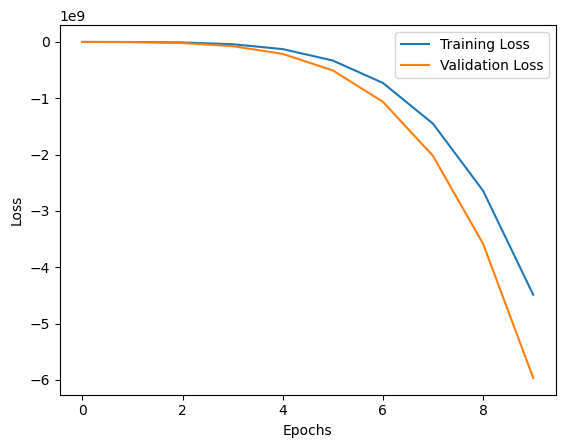

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_predictions = recommendation_model.predict(concatenated_features)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
val_predictions_binary = (val_predictions > 0.5).astype(int)

In [ ]:
ccuracy = accuracy_score(df['encoded_labels'], val_predictions_binary)
precision = precision_score(df['encoded_labels'], val_predictions_binary, average='weighted')
recall = recall_score(df['encoded_labels'], val_predictions_binary, average='weighted')
f1 = f1_score(df['encoded_labels'], val_predictions_binary, average='weighted')

C:\Users\DESTOP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Mean Average Precision (MAP): {average_precision_score}")
print(f"Normalized Discounted Cumulative Gain (NDCG): {ndcg_score}")

Accuracy: 0.001788908732123673
Precision: 3.200194571829967e-06
Recall: 0.0017889087656529517
F1-score: 6.388959877331971e-06
Mean Average Precision (MAP): <function average_precision_score at 0x0000026EBA242520>
Normalized Discounted Cumulative Gain (NDCG): <function ndcg_score at 0x0000026EBA243100>


In [ ]:
from keras.models import load_model
recommendation_model.save('recommendation_model.h5')